In [1]:
%load_ext autoreload
%autoreload 2

# Recommended runtime

We recommend running the gpSLDS on a GPU backend in order to fully utilize computational speedups. For our paper, we ran all experiments using a NVIDIA A100 GPU. 

If you are using Colab, you can change to a GPU runtime by clicking Runtime -> Change runtime type -> A100 GPU.

# Imports

In [2]:
# general imports
import jax
jax.config.update("jax_enable_x64", True)
import jax.numpy as jnp
import jax.random as jr
from jax import vmap

import tensorflow_probability.substrates.jax as tfp
tfd = tfp.distributions

import ssm 
import pickle
import matplotlib.pyplot as plt

In [3]:
# import functions from gpslds codebase
from data.generate_synthetic_data import generate_synthetic_dynamics

from gpslds.kernels import Linear, SSL
from gpslds.transition import SparseGP
from gpslds.likelihoods import PoissonProcess
from gpslds.initialization import initialize_zs
from gpslds.quadrature import GaussHermiteQuadrature
from gpslds.em import fit_variational_em
from gpslds.utils import get_transformation_for_latents, get_posterior_f_mean, get_posterior_f_var, get_most_likely_state, get_learned_partition

# Plotting helper functions

Helper functions for plotting the synthetic data.

In [4]:
def plot_dynamics(dynamics_fn, xlim=(-8, 8), ylim=(-8, 8), n_xpts=20, n_ypts=20, ax=None, figsize=(3, 3), fontsize=12):
    if ax is None:
        fig, ax = plt.subplots(figsize=figsize)

    x, y = jnp.meshgrid(
        jnp.linspace(*xlim, n_xpts),
        jnp.linspace(*ylim, n_ypts)
    )
    input_locs = jnp.column_stack([x.ravel(), y.ravel()])

    fs = vmap(dynamics_fn)(input_locs)
    ax.quiver(input_locs[:,0], input_locs[:,1], fs[:,0], fs[:,1], angles='xy')
    ax.set_title("true dynamics", fontsize=fontsize)
    ax.set_xlabel(r"$x_1$", fontsize=fontsize)
    ax.set_ylabel(r"$x_2$", fontsize=fontsize)
    ax.set_xlim(*xlim)
    ax.set_ylim(*ylim)
    return ax

def plot_dynamics_and_latents(dynamics_fn, latents, xlim=(-8, 8), ylim=(-8, 8), n_xpts=20, n_ypts=20, ax=None, figsize=(3, 3), fontsize=12, alpha=0.5):
    assert latents.shape[-1] == 2
    ax = plot_dynamics(dynamics_fn, xlim=xlim, ylim=ylim, n_xpts=n_xpts, n_ypts=n_ypts, ax=ax, figsize=figsize, fontsize=fontsize)
    for latent in latents:
        ax.plot(latent[:,0], latent[:,1], alpha=alpha)
    ax.set_title("true dynamics & latents")
    return ax

def plot_latents_over_time(t_max, latents_mean, latents_cov=None, ax=None, figsize=(4, 3), fontsize=12, color='red', alpha=0.2):
    if ax is None:
        fig, ax = plt.subplots(figsize=figsize)
    t_grid = jnp.linspace(0, t_max, latents_mean.shape[0])
    latent_dim = latents_mean.shape[-1]

    for i in range(latent_dim):
        ax.plot(t_grid, latents_mean[:,i], color=color)

    if latents_cov is not None:
        for i in range(latent_dim):
            ax.fill_between(t_grid, latents_mean[:,i]+2*jnp.sqrt(latents_cov[:,i,i]),
                    latents_mean[:,i]-2*jnp.sqrt(latents_cov[:,i,i]), facecolor=color, alpha=alpha)

    ax.set_xlabel("time (s)", fontsize=fontsize)
    ax.set_ylabel(r"$x_1(t), x_2(t)$", fontsize=fontsize)
    return ax

# Load in dataset and pLDS emissions

In [5]:
# load in data and initial emissions parameters
data_path = "data/synthetic_data.pkl"
with open(data_path, 'rb') as f:
    dataset = pickle.load(f)
dt, all_xs, all_spikes, C, d = dataset
all_xs = jnp.array(all_xs)
all_spikes = jnp.array(all_spikes)
C = jnp.array(C)
d = jnp.array(d)

emissions_path = "data/synthetic_plds_emissions.pkl"
with open(emissions_path, 'rb') as f:
    elbos, q, C_plds, d_plds = pickle.load(f)
C_plds = jnp.array(C_plds)
d_plds = jnp.array(d_plds)

In [6]:
# select subset of data for fitting
n_trials = 30
inds_to_select = jnp.concatenate((jnp.arange(int(n_trials/2)), jnp.arange(int(len(all_xs)/2), int(len(all_xs)/2)+int(n_trials/2))))
xs = all_xs[inds_to_select]
spikes = all_spikes[inds_to_select]

In [7]:
# get dimensions and constants
latent_dim = xs.shape[-1]
_, n_timesteps, output_dim = spikes.shape
t_max = n_timesteps * dt

# Plot true dynamics, latents, and observations

<Axes: title={'center': 'true dynamics'}, xlabel='$x_1$', ylabel='$x_2$'>

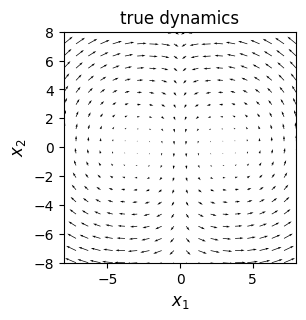

In [8]:
# visualize true dynamics flow field
plot_dynamics(generate_synthetic_dynamics, xlim=(-8, 8), ylim=(-8, 8), n_xpts=20, n_ypts=20)

<Axes: title={'center': 'true dynamics & latents'}, xlabel='$x_1$', ylabel='$x_2$'>

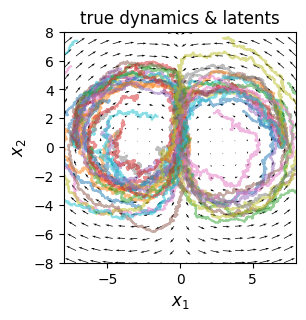

In [9]:
# plot true latent states on top of true dynamics
plot_dynamics_and_latents(generate_synthetic_dynamics, xs, xlim=(-8, 8), ylim=(-8, 8), n_xpts=20, n_ypts=20)

<Axes: xlabel='time (s)', ylabel='$x_1(t), x_2(t)$'>

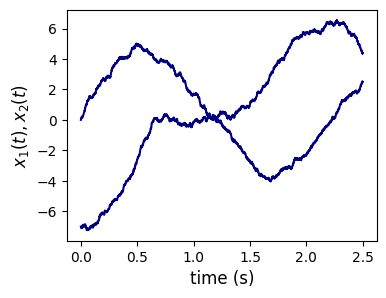

In [10]:
# plot observations for one trial
trial_idx = 0
plot_latents_over_time(t_max, xs[trial_idx], color='navy')

# Initialize the model

In [11]:
# initialize quadrature object and kernel
num_bases = 3
basis_set = lambda x: jnp.array([1., x[0], x[1]])
gh_quad = GaussHermiteQuadrature(latent_dim, n_quad=6)
linear_kernel = Linear(gh_quad)
kernel = SSL(gh_quad, linear_kernel, basis_set=basis_set)

# initialize inducing points and function
zs_lim, M_per_dim = 4, 4
zs = initialize_zs(latent_dim, zs_lim, M_per_dim)
M = zs.shape[0]
fn = SparseGP(zs, kernel)

# initialize likelihood
t_mask = jnp.ones((n_trials, n_timesteps))
trial_mask = jnp.ones((n_trials, n_timesteps))
likelihood = PoissonProcess(spikes, t_mask, dt, gh_quad, link='softplus')

In [12]:
# generate random seeds
key = jr.PRNGKey(1)
key_W, key_fp = jr.split(key, 2)

# intiialize number of linear states and kernel hyperparameters
num_states = 2
W_init = tfd.Normal(0, 1).sample((num_bases, num_states-1), seed=key_W).astype(jnp.float64)
fp_init = tfd.Normal(0, 1).sample((num_states, latent_dim), seed=key_fp).astype(jnp.float64)
tau_init = 0.5
kernel_params_init = {
    "linear_params": [{"fixed_point": fp_init[i]} for i in range(num_states)],
    "log_tau": jnp.log(tau_init),
    "W": W_init
}

# initialize initial conditions for latents from Poisson LDS
x0_init_params = jnp.stack([q.mean_continuous_states[i][0] for i in inds_to_select])

# initialize output parameters from Poisson LDS
output_params_init = {'C': C_plds, 'd': d_plds}

# Fit model

In [13]:
key = jr.PRNGKey(0) # for minibatching; doesn't matter here, since we are using batch_size=n_trials

# set number of total vEM iters
n_iters = 20

# set a learning rate schedule
decay, forgetting_rate = 50, -0.9
learning_rates = (decay + jnp.arange(1, 1 + n_iters)) ** (forgetting_rate)

# fit model
result = fit_variational_em(key,
                            latent_dim,
                            dt,
                            fn,
                            likelihood,
                            trial_mask,
                            output_params_init,
                            kernel,
                            kernel_params_init,
                            inputs=None,
                            m0=x0_init_params,
                            mu0=x0_init_params,
                            n_iters=n_iters,
                            n_iters_e=15,
                            n_iters_m=150,
                            learning_rates=learning_rates,
                            batch_size=n_trials)

# collect results
ms, Ss, As, bs, B, q_u_mu, q_u_sigma, output_params, kernel_params, elbos = result

iter: 0, elbo = 60246.50633076466
iter: 1, elbo = 60587.66339325599
iter: 2, elbo = 60614.54994750441
iter: 3, elbo = 60629.095027671705
iter: 4, elbo = 60639.411039771796
iter: 5, elbo = 60647.11754852045
iter: 6, elbo = 60653.0705039386
iter: 7, elbo = 60657.79575679895
iter: 8, elbo = 60661.6359338124
iter: 9, elbo = 60664.823420945824
iter: 10, elbo = 60667.51999329746
iter: 11, elbo = 60669.840794271135
iter: 12, elbo = 60671.869199873065
iter: 13, elbo = 60673.666497690116
iter: 14, elbo = 60675.27830953307
iter: 15, elbo = 60676.73904441054
iter: 16, elbo = 60678.07496129174
iter: 17, elbo = 60679.30636305588
iter: 18, elbo = 60680.4490805493
iter: 19, elbo = 60681.51565829542


# Plot results

In [14]:
# compute necessary rotation matrices
P = get_transformation_for_latents(C, output_params['C'])

# rotate inferred latents
ms_rot = (P @ ms[...,None]).squeeze(-1)
Ss_rot = P @ Ss @ P.T

<Axes: xlabel='time (s)', ylabel='$x_1(t), x_2(t)$'>

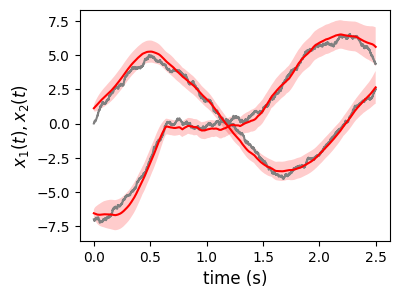

In [15]:
# plot true vs inferred latent states
trial_idx = 0
ax = plot_latents_over_time(t_max, xs[trial_idx], color='gray')
plot_latents_over_time(t_max, ms_rot[trial_idx], Ss_rot[trial_idx], color='red', ax=ax)

In [16]:
# visualize learned dynamics
# generate grid in true generative space
xlim = 8
n_grid = 15
X1, X2 = jnp.meshgrid(
    jnp.linspace(-xlim, xlim, n_grid),
    jnp.linspace(-xlim, xlim, n_grid)
)
Xs_rot = jnp.column_stack([X1.ravel(), X2.ravel()]) # (N**2, 2)

# rotate grid to gpslds inferred space
Xs = jnp.linalg.solve(P, Xs_rot.T).T
Xs_grid = Xs.reshape(n_grid, n_grid, -1)

# generate mean of learned dynamics in gpslds space, then rotate back to true space
f_mean = get_posterior_f_mean(kernel.K, kernel_params, Xs, zs, q_u_mu)
f_mean_rot = (P @ f_mean[...,None]).squeeze(-1)

# compute posterior uncertainty
f_var = get_posterior_f_var(kernel.K, kernel_params, Xs, zs, q_u_sigma[0])
f_cov = vmap(jnp.diag)(jnp.vstack((f_var, f_var)).T)
f_cov_rot = P @ f_cov @ P.T
f_det_rot = vmap(jnp.linalg.det)(f_cov_rot)

Text(0, 0.5, '$x_2$')

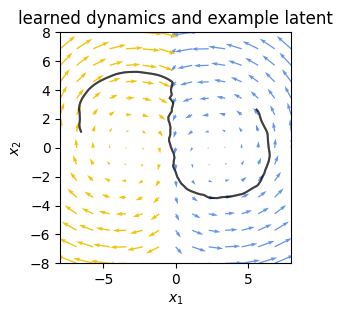

In [17]:
# plot learned dynamics colored by most likely state
trial_idx = 0

fig, ax = plt.subplots(figsize=(3, 3))
most_likely_state = get_most_likely_state(kernel.construct_partition, kernel_params, Xs)
colors = ["cornflowerblue", "#F1C509"]

for i in range(num_states):
    state_inds = (most_likely_state == i).astype(bool)
    ax.quiver(Xs_rot[state_inds,0], Xs_rot[state_inds,1], f_mean_rot[state_inds,0], f_mean_rot[state_inds,1], color=colors[i])
    ax.plot(ms_rot[trial_idx,:,0], ms_rot[trial_idx,:,1], 'k', alpha=0.5)
ax.set_aspect(1.)
ax.set_xlim(-xlim, xlim)
ax.set_ylim(-xlim, xlim)
ax.set_title("learned dynamics and example latent")
ax.set_xlabel(r"$x_1$")
ax.set_ylabel(r"$x_2$")

In [18]:
# compute posterior variance on a finer grid
# generate grid in true generative space
xlim = 8
n_grid_fine = 40
X1_fine, X2_fine = jnp.meshgrid(
    jnp.linspace(-xlim, xlim, n_grid_fine),
    jnp.linspace(-xlim, xlim, n_grid_fine)
)
Xs_rot_fine = jnp.column_stack([X1_fine.ravel(), X2_fine.ravel()]) # (N**2, 2)
Xs_rot_grid_fine = Xs_rot_fine.reshape(n_grid_fine, n_grid_fine, -1)

# rotate to gpslds inferred space
Xs_fine = jnp.linalg.solve(P, Xs_rot_fine.T).T
Xs_grid_fine = Xs_fine.reshape(n_grid_fine, n_grid_fine, -1)

f_var = get_posterior_f_var(kernel.K, kernel_params, Xs_fine, zs, q_u_sigma[0])
f_cov = vmap(jnp.diag)(jnp.vstack((f_var, f_var)).T)
f_cov_rot = P @ f_cov @ P.T
f_det_rot = vmap(jnp.linalg.det)(f_cov_rot)

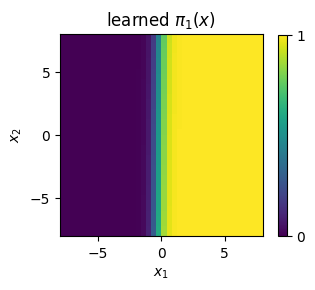

In [19]:
# plot learned partition function
learned_partition = get_learned_partition(kernel.construct_partition, kernel_params, Xs_fine)
learned_partition_grid = learned_partition.reshape(n_grid_fine, n_grid_fine, -1)

fig, ax = plt.subplots(figsize=(3,3))
im = ax.imshow(learned_partition_grid[:,:,0], origin='lower', extent=[-xlim, xlim, -xlim, xlim])
ax.set_aspect(1.)
ax.set_xticks([-5, 0, 5])
ax.set_yticks([-5, 0, 5])
ax.set_title(r"learned $\pi_1(x)$")
ax.set_xlabel(r"$x_1$")
ax.set_ylabel(r"$x_2$")

fig.subplots_adjust(right=.8)
cbar_ax = fig.add_axes([0.85, 0.16, 0.03, 0.67])
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.set_ticks([0, 1])

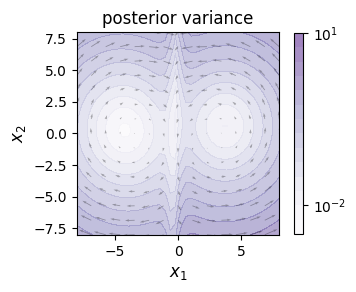

In [20]:
# plot learned dynamics with posterior uncertainty
from matplotlib import ticker, cm

fig, ax = plt.subplots(figsize=(3, 3))

levels = 10**(jnp.linspace(-2.5, 1, 15))
contour = ax.contourf(X1_fine, X2_fine, f_det_rot.reshape(n_grid_fine, n_grid_fine), levels=levels, alpha=0.5, locator=ticker.LogLocator(), cmap='Purples')
ax.quiver(Xs_rot[:,0], Xs_rot[:,1], f_mean_rot[:,0], f_mean_rot[:,1], color='black', alpha=0.3)

ax.set_aspect(1)
ax.set_title("posterior variance", fontsize=12)
ax.set_xlabel(r"$x_1$", fontsize=12)
ax.set_ylabel(r"$x_2$", fontsize=12)

fig.subplots_adjust(right=.8)
cbar_ax = fig.add_axes([0.85, 0.16, 0.03, 0.67])
cbar = fig.colorbar(contour, cax=cbar_ax)

cbar.locator = ticker.LogLocator(10)
cbar.set_ticks([1e-2, 1e1])